In [5]:
import ants
import matplotlib.pyplot as plt
import os
import numpy as np
from ghost.phantom import *
from ghost.calib import *
from ghost.stats import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Read in our images as ants objects
#my_swoop_img = ants.image_read('/Users/petter/Library/CloudStorage/Box-Box/UNITY_Pilot_QA_Study/KCL_CNS/ses01/NIFTI/0004_T2_(AXI)_20230224114519_4.nii')
my_swoop_img = ants.image_read('/Users/petter/Library/CloudStorage/Box-Box/UNITY_Pilot_QA_Study/rawdata/sub-LUND/ses-01/anat/sub-LUND_ses-01_rec-axi_T1std.nii.gz')
my_ref_img = ants.image_read(get_phantom_nii('T1'))

In [3]:
def reg_to_phantom(target_img, phantom_weighting='T1', xfm_type='Affine'):
    """Get transformation object from target image to reference image
    
    Parameters
    ----------
    target_img : antsImage
        The target image. Probably from the swoop.
    
    phantom_weighting : str
        Which weighting (T1 or T2). Default is 'T1'.

    xfm_type : str
        The type of transformation to use. Default is 'Affine'.
        See ANTsPy documentation for other options (https://antspy.readthedocs.io/en/latest/registration.html).

    Returns
    -------
    ANTsTransform
        The transformation object.
    """
    ref_img = ants.image_read(get_phantom_nii(phantom_weighting))
    reg = ants.registration(fixed=ref_img, moving=target_img, type_of_transform=xfm_type)
    return reg['fwdtransforms']

# Run registration and get transform object
xfm = reg_to_phantom(my_swoop_img, phantom_weighting='T1', xfm_type='Affine')

In [11]:
def warp_seg(target_img, xfm=None, weighting=None, seg='T1'):
    """Warp any segmentation to target image
    
    Parameters
    ----------
    target_img : ANTsImage
        The reference image.
    
    xfm : ANTsTransform
        The transformation object.
    
    seg : str
        Which segmentation to use (T1, T2, ADC, LC, fiducials, wedges). Default is 'T1'.
    
    Returns
    -------
    ANTsImage
        The warped segmentation.
    """
    if xfm is None and weighting is None:
        raise ValueError('Either xfm or weighting must be provided')
    elif xfm is not None and weighting is not None:
        raise ValueError('xfm and weighting cannot both be provided')
    elif xfm is None and weighting is not None:
        xfm = reg_to_phantom(target_img, phantom_weighting=weighting, xfm_type='Affine')

    seg = ants.image_read(get_seg_nii(seg))
    seg_warp = ants.apply_transforms(fixed=target_img, moving=seg, whichtoinvert=[1], transformlist=xfm, interpolator='genericLabel')
    return seg_warp

# Apply transformation to given segmentation
T1_seg = warp_seg(target_img=my_swoop_img, weighting='T1', seg='T1')

TypeError: reg_to_phantom() got an unexpected keyword argument 'phantom_weighting'

w1 = 25.50 mm, w2 = 25.50 mm
Theta = 0.00 radians
Slice thickness is 4.50 mm


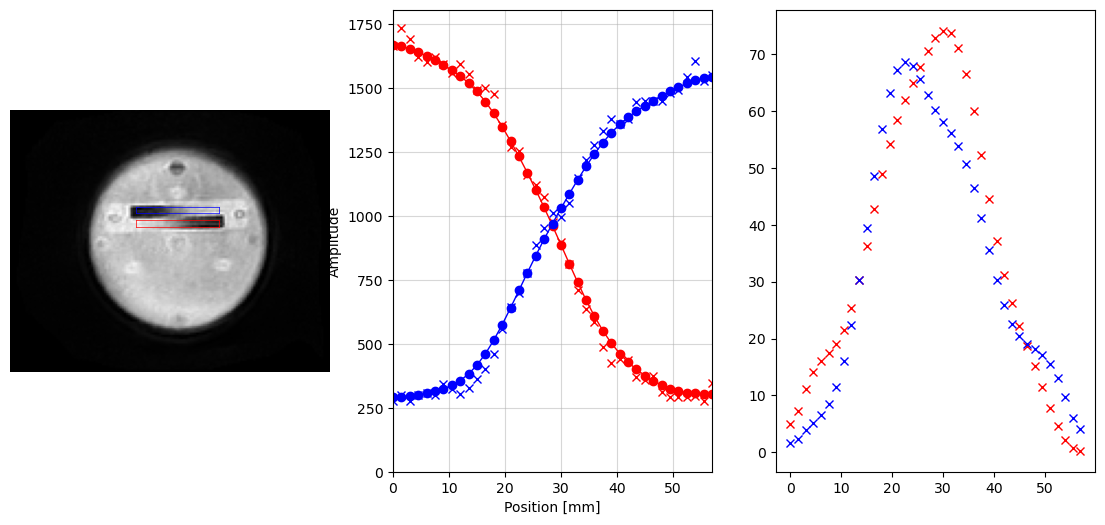

In [15]:
def calculate_slice_thickness_from_wedges(target_img, weighting, slice=31, sigma=3, wedge_angle=10, return_plot_data=False):
    """Calculate slice thickness from wedge segmentations
    
    Parameters
    ----------
    target_img : ANTsImage
        The target image (axi). Probably from the Swoop.

    weighting : str
        Which weighting (T1 or T2).
    sigma : int (optional)
        The sigma value for the Gaussian filter. Default is 3.
    
    wedge_angle : int (optional)
        The wedge angle. Is 10 degrees for the Caliber MRI mini hybrid phantom (model 137).
    
    slice : int (optional)
        The slice number used to acquire the line profile. Note that slice 1 in fsleyes is slice 0 in python. Default is 30.

    Returns
    -------
    t_sl : float
        The slice thickness.
    
    theta : float
        The angle of the image plane with respect to the base of the wedge.
    """
    # Convert ANTsImage to numpy array and extract correct slice
    img = target_img.numpy()
    img = img[:,:,slice]

    # Get wedge segmentation
    wseg = warp_seg(target_img, weighting=weighting, seg='wedges')[:,:,slice]
    wseg1 = wseg == 1
    wseg2 = wseg == 2

    id1, id2 = np.where(wseg1), np.where(wseg2)

    min_i1, max_i1 = np.min(id1[0]), np.max(id1[0])+1
    min_j1, max_j1 = np.min(id1[1]), np.max(id1[1])+1
    min_i2, max_i2 = np.min(id2[0]), np.max(id2[0])+1
    min_j2, max_j2 = np.min(id2[1]), np.max(id2[1])+1

    if abs(min_j1-max_j1) == abs(min_j2-max_j2):
        yz_plane1 = img[min_i1:max_i1, min_j1:max_j1]
        yz_plane2 = img[min_i2:max_i2, min_j2:max_j2]
    elif abs(min_j1-max_j1) > abs(min_j2-max_j2):
        yz_plane1 = img[min_i1:max_i1, min_j1:max_j2]
        yz_plane2 = img[min_i2:max_i2, min_j2:max_j2]
        print("Warning, wedge 1 is longer than wedge 2")
    else:
        yz_plane1 = img[min_i1:max_i1, min_j1:max_j1]
        yz_plane2 = img[min_i2:max_i2, min_j2:max_j1]
        print("Warning, wedge 2 is longer than wedge 1")

    lp = np.stack((np.mean(yz_plane1, axis=0),np.mean(yz_plane2, axis=0))) # line profile
    
    x = np.arange(lp.shape[1])*target_img.spacing[1]

    # Filter the data with a Gaussian window to make it differentiable
    lp_smooth = ndi.gaussian_filter1d(lp, sigma, 1)

    # Differentiate the data with respect to image position
    lp_diff = np.abs(np.gradient(lp_smooth, axis=1))

    # Compute the projected wedge thicknesses
    w_start = np.zeros(2)
    w_end = np.zeros(2)
    w = np.zeros(2)
    for i in range(2):
        # Find the indices of the line profile where the derivative is closest to half the maximum derivative
        w_start[i] = min(range(0, np.argmax(lp_diff[i])), key=lambda j: abs(lp_diff[i][j]-np.max(lp_diff[i])/2))
        w_end[i] = min(range(np.argmax(lp_diff[i]), len(lp_diff[i])), key=lambda j: abs(lp_diff[i][j]-np.max(lp_diff[i])/2))

        # Calculate the wedge thickness
        w[i] = x[int(w_end[i])] - x[int(w_start[i])]
    
    # Calculate theta (the angle of the image plane with respect to the angle of the wedge)
    theta = 1 / 2 * np.arcsin((w[1] - w[0]) * np.sin(2 * np.radians(10)) / sum(w))

    # Calculate theta (the angle of the image plane with respect to the base of the wedges)
    theta = 1 / 2 * np.arcsin((w[1] - w[0]) * np.sin(2 * np.radians(10)) / sum(w))

    # Get the slice thickness
    slice_thickness = w[0]  * np.tan(np.radians(wedge_angle) + theta)

    if return_plot_data:
        # Make dictionary of variables needed to plot the slice thickness distributions
        plot_data = {'lp': lp, 'lp_smooth': lp_smooth, 'lp_diff': lp_diff, 'x': x, 'wseg': wseg, 'slice': slice}
        return slice_thickness, w, theta, plot_data
    else:
        return slice_thickness, w, theta

# Calculate slice thickness
# This script does all the warping of wedge segmentations in it already
slice_thickness, w, theta, plot_data = calculate_slice_thickness_from_wedges(my_swoop_img, 'T1', sigma=3, return_plot_data=True)

print('w1 = {:.2f} mm, w2 = {:.2f} mm'.format(w[0], w[1]))
print('Theta = {:.2f} radians'.format(theta))
print('Slice thickness is {:.2f} mm'.format(slice_thickness))

plot_slice_thickness_distribution(plot_data, my_swoop_img)

In [14]:
def plot_slice_thickness_distribution(plot_data, target_img):
    """
    Plots the slice thickness distribution for a given slice.
    
    Parameters
    ----------
    plot_data : dict
        A dictionary of variables needed to plot the slice thickness distribution.

    target_img : ANTsImage
        The target image (axi). Probably from the Swoop.
    """
    # Unpack dictionary
    for key, value in plot_data.items():
        locals()[key] = value

    seg1 = wseg == 1
    seg2 = wseg == 2

    id1 = np.where(seg1)
    h_1 = np.arange(np.min(id1[0]), np.max(id1[0])+1)
    id2 = np.where(seg2)
    h_2 = np.arange(np.min(id2[0]), np.max(id2[0])+1)

    x0 =  np.min(id1[1])
    l = lp.shape[1]-1

    fig = plt.figure(figsize=(14,6))
    plt.tight_layout()

    #
    # SUBPLOT 1
    #
    fig.add_subplot(1,3,1)

    # Plot phantom slice
    plt.imshow(my_swoop_img[:,:,slice], cmap='gray'); plt.axis('off')

    # Plot rectangular ROI over each wedge
    lw = 0.5
    plt.plot([x0,x0+l], [h_1[0],h_1[0]], '-r', linewidth=lw)
    plt.plot([x0,x0+l], [h_1[-1],h_1[-1]], '-r', linewidth=lw)
    plt.plot([x0,x0], [h_1[0],h_1[-1]], '-r', linewidth=lw)
    plt.plot([x0+l,x0+l],[h_1[0],h_1[-1]], '-r', linewidth=lw)
    plt.plot([x0,x0+l], [h_2[0],h_2[0]], '-b', linewidth=lw)
    plt.plot([x0,x0+l], [h_2[-1],h_2[-1]], '-b', linewidth=lw)
    plt.plot([x0,x0], [h_2[0],h_2[-1]], '-b', linewidth=lw)
    plt.plot([x0+l,x0+l], [h_2[0],h_2[-1]], '-b', linewidth=lw)

    #
    # SUBPLOT 2
    #
    # In subplot 2, the plot shows the mean intensity along each wedge with respect to image position (x) and the fitted Gaussian curves
    fig.add_subplot(1,3,2)
    plt.plot(x, lp[0], 'xr', linewidth=1)
    plt.plot(x, lp[1], 'xb', linewidth=1)
    plt.plot(x, lp_smooth[0], '-or', linewidth=1)
    plt.plot(x, lp_smooth[1], '-ob', linewidth=1)
    plt.xlabel('Position [mm]')
    plt.ylabel('Amplitude')
    plt.grid(alpha=0.5)
    plt.axis([0,max(x), 0, None])

    #
    # SUBPLOT 3
    #
    # In subplot 3, the plot shows the derivative of the mean intensity along each wedge with respect to image position (x), fitted to a Gaussian distribution.
    fig.add_subplot(1,3,3)
    plt.plot(x, lp_diff[0], 'xr')
    plt.plot(x, lp_diff[1], 'xb')
    #plt.plot(x,  [0], '--r', linewidth=1)
    #plt.plot(x, lp_fit[1], '--b', linewidth=1)

    plt.show()

In [8]:
# def parse_rois(target_img, weighting, seg):
#     """ Parses the ROI values from a segmentation image

#     Parameters
#     ----------
#     target_img : ANTsImage
#         The target image (axi). Probably from the Swoop.
    
#     seg : str
#         Which segmentation to use (T1, T2, ADC, LC, fiducials, wedges). Default is 'T1'.
    
#     Returns
#     -------
#     stats : pandas dataframe
#         A dataframe with LabelValue, mean, min, max, variance, count, volume.
#     """
#     # Get the segmentation image
#     seg_img = warp_seg(target_img=target_img, weighting=weighting, seg=seg)
    
#     # Get the ROI values
#     stats = ants.label_stats(target_img, seg_img)
#     stats = stats.drop(stats[stats['LabelValue'] == 0].index)
#     stats = stats.drop(columns=['Mass', 'x', 'y', 'z', 't'])
 
#     return stats

# Parse the ROI values, get mean and sd. Dataframe with ID, mean, SD
T2_stats = parse_rois(my_swoop_img, weighting='T2', seg='T2')
T1_stats = parse_rois(my_swoop_img, weighting='T1', seg='T1')
print(f"T2_stats = \n {T2_stats}")

T2_stats = 
     LabelValue         Mean    Min     Max      Variance  Count       Volume
12         1.0   332.652778   23.0  1202.0  62096.013760  216.0  2764.800293
9          2.0   357.638614    2.0  1478.0  83783.585168  202.0  2585.600342
4          3.0   407.666667   24.0  1105.0  29296.244328  192.0  2457.600098
3          4.0   557.921182  184.0  1175.0  31891.775935  203.0  2598.400146
0          5.0   890.344086  460.0  1731.0  32468.659343  186.0  2380.800293
2          6.0  1021.228261  473.0  1705.0  31939.849252  184.0  2355.200195
10         7.0  1086.336842  274.0  1403.0  31317.822445  190.0  2432.000244
13         8.0  1367.353234  520.0  1819.0  49080.359602  201.0  2572.800293
7          9.0  1591.353535  438.0  2222.0  81074.808388  198.0  2534.400146
6         10.0  1711.910000  575.0  2243.0  59828.876281  200.0  2560.000244
1         11.0  1697.407035  800.0  2275.0  62253.414294  199.0  2547.200195
11        12.0  1504.459184  685.0  1994.0  48984.413710  196.0

In [2]:
# Parse calibration values. Make this into an object which is initiated with this function.
# Then we can call functions on this object to get specific data values
calib = Calibration(fname='/Users/petter/Library/CloudStorage/Box-Box/Hyperfine/CaliberPhantom/Calibration/reference_measurements_137-0004.xlsx')

# Look at the calib.py file, the calibration file should be a Python object which you initiate by giving the file path. 
# Need to get the following
df_dict = calib.data

In [3]:
# Concentration is the same at each temperature and field strength, needs no input. T1 is the NiCl
T1_conc = calib.get_T1_conc()
T2_conc = calib.get_T2_conc()

print(f"T1_conc = \n {T1_conc}")
print(f"T2_conc = \n {T2_conc}")

T1_conc = 
 [ 0.29  0.6   1.04  1.64  2.52  3.68  5.43  7.74 11.3  16.5  23.3  32.7
 46.   65.3 ]
T2_conc = 
 [0.0113 0.0181 0.0282 0.0434 0.0673 0.0934 0.1353 0.193  0.2768 0.4276
 0.5555 0.7902 1.1274 1.5996]


In [6]:
mimics = 'T1'
temp = 20
sheets = {'T1': 'NiCl_3T', 'T2': 'MnCl_3T'}
sheet = sheets.get(mimics)
column = 'T1' if mimics == 'T1' else 'T2'

df = df_dict.get(sheet)
if temp not in range(16, 27, 2):
    raise ValueError('Temperature not available. Available temperatures are 16, 18, 20, 22, 24 and 26 degrees Celsius')
else:
    T1_at_20deg = df.loc[df['Temperature (C)'] == temp, column + ' (ms)'].values

print(f"T1_at_20deg = \n {T1_at_20deg}")

T1_at_20deg = 
 [1884.  1330.2  987.3  690.1  485.   341.6  240.9  174.9  121.1   85.8
   60.2   42.9   30.4   21.4]


In [4]:
# Get T1 or T2 values at a specific temperature or field strength. 
# Throw warning if trying to get B0 or temp values that are out of range
# We can get T1 and T2 values for all the different mimics. T1, T2 and ADC
qT1_vals = calib.get_T1_vals(mimics='T1', temp=20)
qT2_vals = calib.get_T2_vals(mimics='T2', temp=20)

print(f"qT1_vals = \n {qT1_vals}")
print(f"qT2_vals = \n {qT2_vals}")

qT1_vals = 
 [1884.  1330.2  987.3  690.1  485.   341.6  240.9  174.9  121.1   85.8
   60.2   42.9   30.4   21.4]
qT2_vals = 
 [2478.2 2185.5 1901.3 1550.  1197.6 1026.4  805.1  600.   431.2  292.9
  226.5  158.2  116.7   82.5]


In [ ]:
# For this one we need to mix and match. Not sure how to treat this yet. Wait with this one.
ADC_vals = calib.get_ADC_vals

In [ ]:
#################################################################
# We can also envision this done with one function

my_swoop_fname = '<fname>'
contrast = 'T1'
output_dir = '<my_dir>'
output_basename = 'swoop_T1'

process_all(my_swoop_fname, contrast, output_basename, output_dir)
# This will then create a new folder (if needed) and save segmentations and xfm as
# output_dir/output_basename_T1 / T2 / ADC etc.
# This script could then easily be wrapped into a bash script

In [ ]:
# def save_xfm(xfm, filename): # not meaningful
#     """Save the transformation object to a file
    
#     Parameters
#     ----------
#     xfm : ANTsTransform
#         The transformation object.
    
#     filename : str
#         Filename of transform (file extension is ".mat" for affine transforms).
#     """
#     return ants.write_transform(xfm, filename)

# # Can be nice to have this saved
# filename = '/Users/petter/Documents/Work/temp/xfm.txt'
# save_xfm(xfm, filename)
# def save_seg(seg, filename):
#     """Save segmentation to file
    
#     Parameters
#     ----------
#     seg : ANTsImage
#         The segmentation image.
    
#     filename : str
#         Filename of segmentation (file extension is ".nii.gz").
#     """
#     ants.image_write(seg, filename)

# # Will be a useful function
# save_seg(T1_seg, filename)

In [2]:
import pandas_datareader as web

# Get the data for the stock AAPL
stock_data = web.stooq.StooqDailyReader('AAPL', '01/01/2020').read()
stock_data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-03,148.045,151.1100,147.33,151.03,70732297.0
2023-03-02,144.380,146.7100,143.90,145.91,52279761.0
2023-03-01,146.830,147.2285,145.01,145.31,55478991.0
2023-02-28,147.050,149.0800,146.83,147.41,50546998.0
2023-02-27,147.710,149.1700,147.45,147.92,44998470.0
